这篇文章通过 手写数字识别 来讨论分类问题

In [170]:
# 准备工作
#准备工作

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='internal')

# 图片存储目录
PROJECT_ROOT_DIR = '../'
CHAPTER_ID = 'classifiction'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### MNIST 数据集


作为机器学习的hello world 项目，每当有新的机器学习算法时，该数据集就会被用于评估该模型的性能。

In [171]:
from sklearn.datasets import fetch_mldata 
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

如上方法通过 函数从网络上下载数据集，默认保存在 ` $HOME/scikit_learn_data.`目录。  
通过sklearn 下载的数据都有以下结构：  
1. DESCR：数据集的描述
2. data： 数据集的数据，每行是一个实例， 每列是一个特征。
3. target: 数据集的标签，即需要预测的值。

In [172]:
X, y = mnist["data"], mnist["target"]

In [173]:
X.shape

(70000, 784)

In [174]:
y.shape

(70000,)

如上，包含该70000张图片，每张图片有28 * 28 个像素，共计784个特征。   
可以对每张图片进行可视化。

保存图片: some_digit_plot


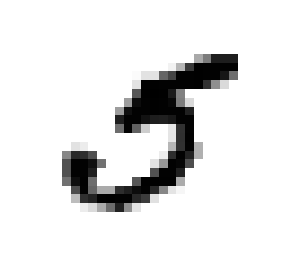

In [175]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [176]:
y[36000] #可以看到图片和标签都为5.

5.0

In [177]:
# 定义一个函数来查看图片
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

保存图片: more_digits_plot


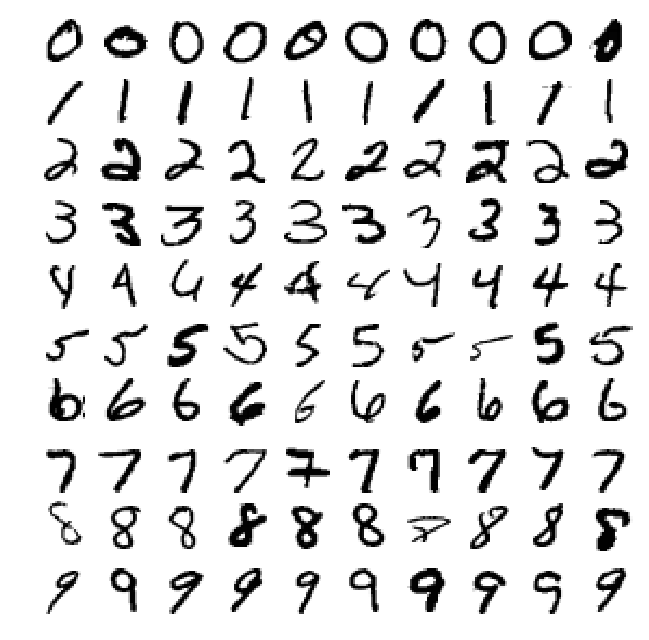

In [178]:
# 查看更多图片， 10 * 10
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600],  X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [179]:
# 切分测试集用于后续预测
X_train, y_train, X_test, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [180]:
# 由于该训练集对于顺序没有要求，不像股票数据或者天气数据。不是一般性，将其随机打乱
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

### 训练一个二元分类器

从一个简单的为开始识别手写数字。首先判断一个实例是否为5.  
目标向量：

In [181]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([False, False, False, ...,  True,  True,  True])

现在可以找一个分类器对其训练。从 随机梯度下降分类器开始，优点在神将网络中也有提到，能快速处理大的数据集, 非常适合在线学习。

In [182]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])  # 可以看到对图片 5 预测正确， 返回true。

array([ True])

### 评估性能

评估分类模型的精确度要比回归模型复杂的多。下面使用交叉验证来对该模型进行评估：

In [183]:
# 交叉验证， 为了保证随机抽样，可以自定义交叉验证方法，进行随机抽样。
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90315, 0.9519 , 0.96815])

In [184]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    

0.96195
0.9521
0.95015


In [185]:
# 看起来精确度还不错，下面定义一个最简单的分类器：
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #永远返回0， 即预测等于5失败。

In [186]:
# 猜一下精确度
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90695, 0.9093 , 0.9127 ])

上述结果也有90的精确度，因为对于本次训练来说，不是5的比率在90%， 因此无论怎么训练，精确度最低都在90%。  
这说明了为什么精度通常不是用于分类器的首选性能度量， 特别是在某些类出现的比较频繁时。

### Confusion Matrix : 混淆矩阵